# Dev. #8 | Sampling Rateの確認

- ひとまず、ファイルごとのサンプリングレートは一定であると考える。

## [1] Confidence値の分布の確認

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("notebook", "whitegrid")

In [2]:
df = pd.read_csv("./data/U0002_S0100_cleaned.csv")
print(df.shape)

(49720, 258)


In [3]:
df.head()

,timestamp,body_index,J00_P0,J00_P1,J00_P2,J00_O0,J00_O1,J00_O2,J00_O3,J00_CONF,...,J30_O3,J30_CONF,J31_P0,J31_P1,J31_P2,J31_O0,J31_O1,J31_O2,J31_O3,J31_CONF
0,2021-10-22 02:15:46.000406016,0,47.8702,348.741,2230.89,0.550014,-0.434476,0.474469,-0.532536,2,...,0.162899,2,-18.7838,-187.917,2152.40,0.630032,-0.257972,0.613827,-0.399658,2
1,2021-10-22 02:15:46.066406016,0,47.8702,348.741,2230.89,0.550014,-0.434476,0.474469,-0.532536,2,...,0.162899,2,-18.7838,-187.917,2152.40,0.630032,-0.257972,0.613827,-0.399658,2
2,2021-10-22 02:15:46.132406016,0,46.8710,351.886,2230.96,0.549369,-0.436875,0.473526,-0.532078,2,...,0.193177,2,-15.2510,-198.904,2153.60,0.653550,-0.291262,0.585977,-0.380356,2
3,2021-10-22 02:15:46.198406016,0,47.0129,353.611,2231.05,0.549459,-0.437178,0.473282,-0.531952,2,...,0.222863,2,-8.1355,-215.948,2156.89,0.665434,-0.370231,0.545385,-0.350259,2
4,2021-10-22 02:15:46.264406016,0,42.4397,363.462,2242.18,0.572130,-0.413092,0.451773,-0.545823,2,...,0.241729,2,-12.7205,-215.574,2146.01,0.657378,-0.317591,0.606166,-0.315521,2


In [4]:
cols = [f"J{ind:0=2}_CONF" for ind in range(32)]

df_conf = df[cols]
print(df_conf.shape)

(49720, 32)


In [5]:
df_conf.head()

,J00_CONF,J01_CONF,J02_CONF,J03_CONF,J04_CONF,J05_CONF,J06_CONF,J07_CONF,J08_CONF,J09_CONF,...,J22_CONF,J23_CONF,J24_CONF,J25_CONF,J26_CONF,J27_CONF,J28_CONF,J29_CONF,J30_CONF,J31_CONF
0,2,2,2,2,2,2,2,2,0,0,...,2,1,1,1,2,2,2,2,2,2
1,2,2,2,2,2,2,2,2,0,0,...,2,1,1,1,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,0,0,...,2,1,1,1,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,0,2,...,2,1,1,1,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,0,2,...,2,1,1,1,2,2,2,2,2,2


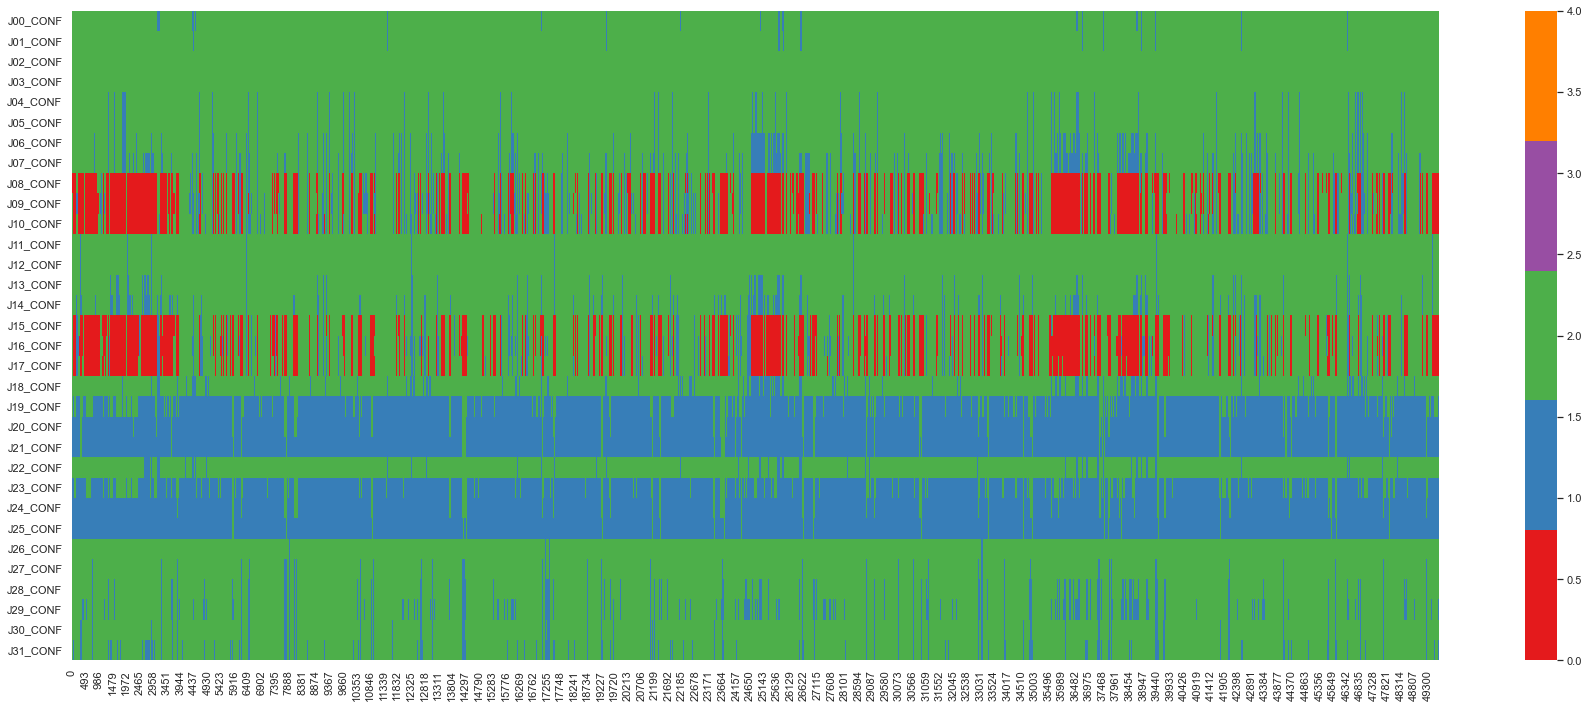

In [6]:
cmap = sns.color_palette("Set1", 5)

fig, ax = plt.subplots(1, 1, figsize=(25,10))
ax = sns.heatmap(
    df_conf.T, cmap=cmap, 
    vmin=0, vmax=4,
)

fig.tight_layout()
# fig.show()
fig.savefig("./figs/K4ABT_ConfMap.pdf")

- Confidenceの値
    - 現在のSDKでは、 以下がサポート
        - 0 = Out of Range
        - 1 = Low
        - 2 = Medium
    - 3 = Highは、今後のSDKアップデートのためのPlace Holder
- Lowなkey Points
    - J19, J20, J21 = Left Hip/Knee/Ankle
    - J23, J24, J25 = Left Hip/Knee/Ankle
        - pos.txt: 0 で埋める
        - Unity: 初期値から更新しない or SPINEからの相対位置で固定
- 下半身以外のコンフィデンスが低い関節
    - OutOfRangeと同じ扱いをする。
    - 0の値で埋め、読み込んだ際に0だった場合は更新をしない？
- Out of RangeなKey Points
    - J08, J09, J10 = Left Wrist/Hand/Handtip
    - J15, J16, J17 = Right Wrist/Hand/Handtip
    - 箱のオクルージョンなどでカメラかに映らない箇所か？
        - pos.txt: (ひとまず) 0に置き換え
        - Unity: 0の場合は、更新しない。

## [2] フィルタの実装

In [68]:
def update_lower_body_key_points(df):
    lower_body_key_points = [
        19, 20, 21,
        23, 24, 25,
    ]
    
    for ind in lower_body_key_points:
        for axis in [0, 1, 2]:
            df[f"J{ind:0=2}_P{axis}"] = 0.0
            df[f"J{ind:0=2}_O{axis+1}"] = 0.0
            
        df[f"J{ind:0=2}_O0"] = 1.0
        
    return df


def update_out_of_range_key_points(df):
    NUM_K4ABT_JOINTS = 32
    K4ABT_OUT_OF_RANGE = 0
    
    # Replace OutOfRange data points with NaN
    for ind in range(NUM_K4ABT_JOINTS):
        cols = [
            f"J{ind:0=2}_P0", f"J{ind:0=2}_P1", f"J{ind:0=2}_P2",
            f"J{ind:0=2}_O1", f"J{ind:0=2}_O2", f"J{ind:0=2}_O3",
        ]
        
        ind_out = df[df[f"J{ind:0=2}_CONF"] == K4ABT_OUT_OF_RANGE].index
        df.loc[ind_out, cols] = 0.0
        df.loc[ind_out, f"J{ind:0=2}_O0"] = 0.0
        
        # # Fill NaN with method="ffill"
        # df[cols] = df[cols].fillna(method="ffill")
    return df




def update_low_confidence_key_points(df):
    NUM_K4ABT_JOINTS = 32
    K4ABT_OUT_OF_RANGE = 0
    K4ABT_LOW_CONF = 1
    EXCLUDE_JOINTS = (
        19, 20, 21,
        23, 24, 25,
    )
    
    # Replace OutOfRange data points with NaN
    for ind in range(NUM_K4ABT_JOINTS):
        if ind in EXCLUDE_JOINTS:
            continue
        cols = [
            f"J{ind:0=2}_P0", f"J{ind:0=2}_P1", f"J{ind:0=2}_P2",
            f"J{ind:0=2}_O0", f"J{ind:0=2}_O1", f"J{ind:0=2}_O2", f"J{ind:0=2}_O3",
        ]
        
        ind_out = df[df[f"J{ind:0=2}_CONF"] == K4ABT_LOW_CONF].index
        print(ind, len(ind_out))
        df.loc[ind_out, cols] = np.nan
        
        # Fill NaN with method="ffill"
        df[cols] = df[cols].fillna(method="ffill")
    return df


def apply_median_filter(df, win_size=5):
    """Apply Median filter to keypoints sequence.
    
    """
    NUM_K4ABT_JOINTS = 32
    K4ABT_OUT_OF_RANGE = 0
    K4ABT_LOW_CONF = 1
    EXCLUDE_JOINTS = (
        19, 20, 21,
        23, 24, 25,
    )
    
    cols = []
    for ind in range(NUM_K4ABT_JOINTS):
        if ind in EXCLUDE_JOINTS:
            continue   
        cols += [
            f"J{ind:0=2}_P0", f"J{ind:0=2}_P1", f"J{ind:0=2}_P2",
            f"J{ind:0=2}_O0", f"J{ind:0=2}_O1", f"J{ind:0=2}_O2", f"J{ind:0=2}_O3",
        ]
    
    df[cols] = df[cols].rolling(win_size, axis=0).median()
    return df


In [98]:
df_new = df.copy()

df_new = update_lower_body_key_points(df_new)
# df_new = update_low_confidence_key_points(df_new)
df_new = update_out_of_range_key_points(df_new)

df_new2 = apply_median_filter(df_new.copy())

In [99]:
df_new.iloc[:10, (19*8):(25*8)]

,J18_O3,J18_CONF,J19_P0,J19_P1,J19_P2,J19_O0,J19_O1,J19_O2,J19_O3,J19_CONF,...,J23_O1,J23_O2,J23_O3,J23_CONF,J24_P0,J24_P1,J24_P2,J24_O0,J24_O1,J24_O2
0,-0.696837,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,...,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.696837,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,...,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.691153,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,...,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.668369,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,...,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.682247,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,...,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0
5,-0.610970,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,...,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0
6,-0.579127,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,...,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0
7,-0.579549,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,...,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0
8,-0.572356,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,...,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0
9,-0.577414,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,...,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0


In [100]:
df_new.iloc[:-10, (8*8):(11*8)]

,J07_O3,J07_CONF,J08_P0,J08_P1,J08_P2,J08_O0,J08_O1,J08_O2,J08_O3,J08_CONF,...,J09_O1,J09_O2,J09_O3,J09_CONF,J10_P0,J10_P1,J10_P2,J10_O0,J10_O1,J10_O2
0,0.967152,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.967152,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.958306,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.914371,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,-0.404163,0.024021,0.900748,2,0.0,0.0,0.0,0.0,0.0,0.0
4,0.845982,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,-0.522872,0.096929,0.839862,2,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49705,0.081000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0
49706,0.081000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0
49707,0.081000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0
49708,0.081000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
df_new

,timestamp,body_index,J00_P0,J00_P1,J00_P2,J00_O0,J00_O1,J00_O2,J00_O3,J00_CONF,...,J30_O3,J30_CONF,J31_P0,J31_P1,J31_P2,J31_O0,J31_O1,J31_O2,J31_O3,J31_CONF
0,2021-10-22 02:15:46.000406016,0,47.8702,348.741,2230.89,0.550014,-0.434476,0.474469,-0.532536,2,...,0.162899,2,-18.7838,-187.917,2152.40,0.630032,-0.257972,0.613827,-0.399658,2
1,2021-10-22 02:15:46.066406016,0,47.8702,348.741,2230.89,0.550014,-0.434476,0.474469,-0.532536,2,...,0.162899,2,-18.7838,-187.917,2152.40,0.630032,-0.257972,0.613827,-0.399658,2
2,2021-10-22 02:15:46.132406016,0,46.8710,351.886,2230.96,0.549369,-0.436875,0.473526,-0.532078,2,...,0.193177,2,-15.2510,-198.904,2153.60,0.653550,-0.291262,0.585977,-0.380356,2
3,2021-10-22 02:15:46.198406016,0,47.0129,353.611,2231.05,0.549459,-0.437178,0.473282,-0.531952,2,...,0.222863,2,-8.1355,-215.948,2156.89,0.665434,-0.370231,0.545385,-0.350259,2
4,2021-10-22 02:15:46.264406016,0,42.4397,363.462,2242.18,0.572130,-0.413092,0.451773,-0.545823,2,...,0.241729,2,-12.7205,-215.574,2146.01,0.657378,-0.317591,0.606166,-0.315521,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49715,2021-10-22 03:10:27.190406016,0,-26.1675,430.787,2143.76,0.549024,-0.481235,0.477479,-0.488875,2,...,0.029465,2,-73.9943,-205.216,2076.14,0.556356,-0.514802,0.400681,-0.514686,2
49716,2021-10-22 03:10:27.256406016,0,-29.2062,429.135,2139.61,0.557384,-0.476080,0.466488,-0.495036,2,...,0.028338,2,-67.3737,-207.069,2085.86,0.537645,-0.571698,0.369494,-0.497569,2
49717,2021-10-22 03:10:27.322406016,0,-15.0730,432.998,2153.37,0.538753,-0.478877,0.515343,-0.463514,2,...,0.008500,2,-75.4047,-203.674,2071.37,0.543608,-0.513861,0.397306,-0.531587,2
49718,2021-10-22 03:10:27.388406016,0,-23.7669,430.162,2146.12,0.549121,-0.481404,0.491996,-0.473979,2,...,-0.002577,2,-72.6258,-204.590,2077.96,0.528497,-0.539769,0.382318,-0.532141,2


<AxesSubplot:>

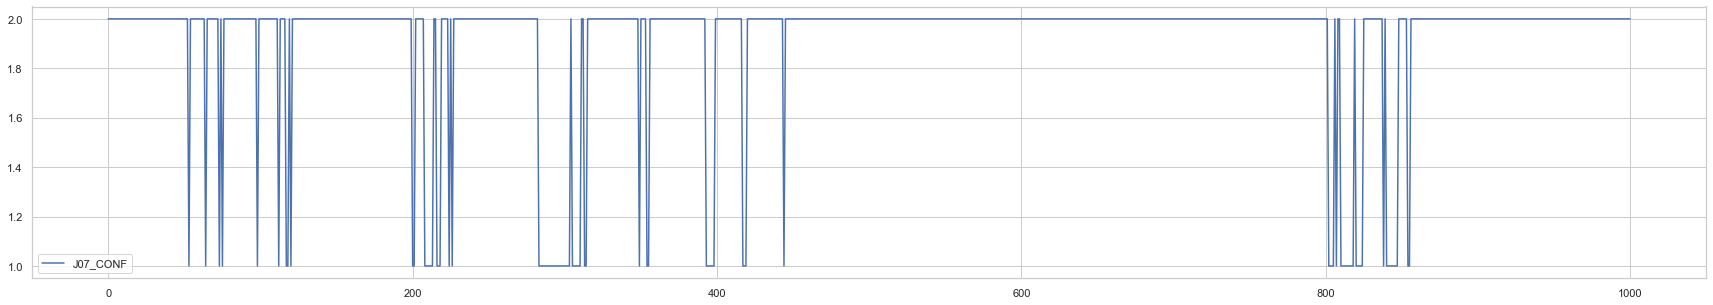

In [102]:
df_new.loc[:1000, :][["J07_CONF"]].plot(kind="line", figsize=(30, 5))

<AxesSubplot:>

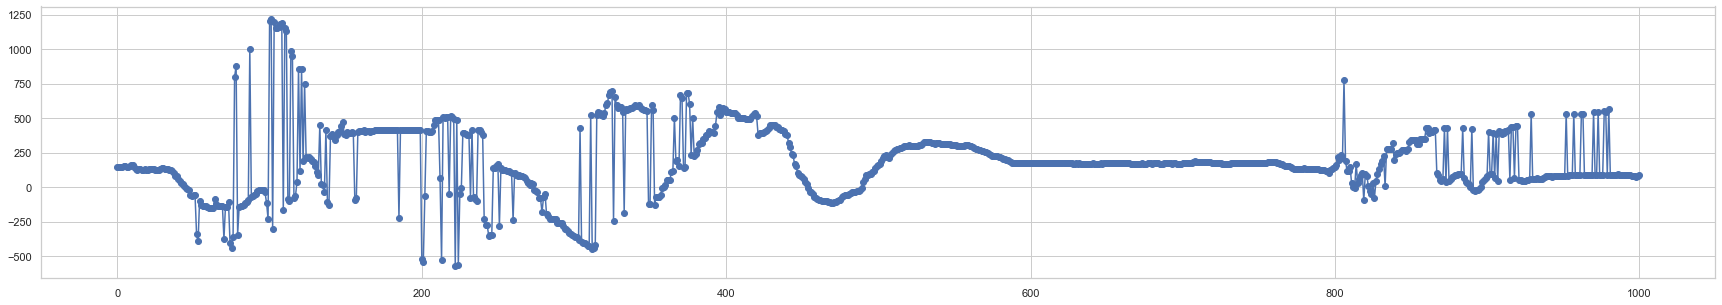

In [103]:
df_new.loc[:1000, :]["J07_P0"].plot(kind="line", marker="o",  figsize=(30, 5))

<AxesSubplot:>

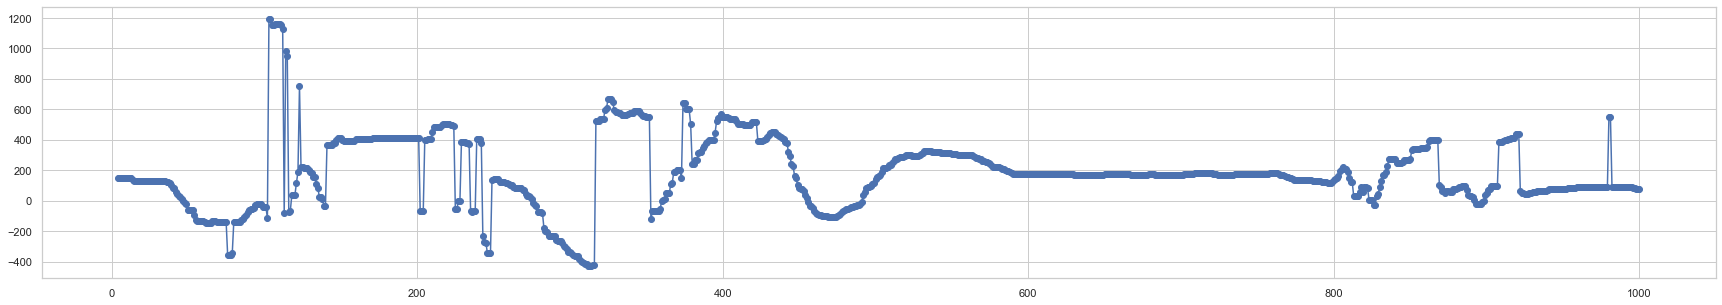

In [104]:
df_new2.loc[:1000, :]["J07_P0"].plot(kind="line", marker="o",  figsize=(30, 5))

In [97]:
1000 / 15

66.66666666666667